In [8]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import zipfile


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir /content/FRACTURE.FAKHREDINPart1

In [5]:
!cp -r /content/drive/MyDrive/farabi/FRACTURE.FAKHREDINPart1.zip -t /content

In [6]:
!cp -r /content/drive/MyDrive/farabi/68Case.csv -t /content

In [9]:
zip_ref = zipfile.ZipFile("/content/FRACTURE.FAKHREDINPart1.zip", "r")
zip_ref.extractall('/content/FRACTURE.FAKHREDINPart1')
zip_ref.close()

In [14]:
def index_generator(len_data):
    if len_data > 33:
        mid = int(len_data/2)+1
        start = max(1,mid - 20)+1
        end = start + 32
        select = np.arange(start,end,1)
    else:
        select = np.arange(2,len_data+1,1)
        x = np.random.choice(select,32-len(select))
        select = np.append(select , x)
        select = np.sort(select)
    return select

def read_image(X_dir,X_index):
    X_stack = np.zeros((256,256,32))
    i = 0
    for a in X_index:
        try:
            img = cv2.imread(f'{X_dir}/{a:03}.jpg',0)
            img = cv2.resize(img,(256,256))

        except:
            try:
                img = cv2.imread(f'{X_dir}/{(a+1):03}.jpg',0)
                img = cv2.resize(img,(256,256))
            except:
                img = cv2.imread(f'{X_dir}/{(a-1):03}.jpg',0)
                img = cv2.resize(img,(256,256))

        X_stack[:,:,i] = img
        i=i+1
    return X_stack

def C_resize(X_stack):
    new_X_stack = np.zeros((128,128,32))
    for i in range(32):
        img = X_stack[:,:,i]
        new_img = (cv2.resize(img[80:180,25:225],(128,64)))
        new_X_stack[:,:,i] = np.concatenate((new_img,new_img*0),0)
    return new_X_stack

def S_resize(X_stack):
    new_X_stack = np.zeros((128,128,32))
    for i in range(32):
        img = X_stack[:,:,i]
        new_X_stack[:,:,i] = (cv2.resize(img[60:210,50:200],(128,128)))

    return new_X_stack

def A_resize(X_stack):
    new_X_stack = np.zeros((128,128,32))
    for i in range(32):
        img = X_stack[:,:,i]
        new_X_stack[:,:,i] = (cv2.resize(img[40:200,40:200],(128,128)))

    return new_X_stack

In [15]:
def load_image():
    data = pd.read_csv('/content/68Case.csv')
    num_data = len(os.listdir('/content/FRACTURE.FAKHREDINPart1'))
    const_pixel_dims = (num_data, 128, 128, 96)
    i = 0
    img_set = np.zeros(const_pixel_dims, dtype=np.float32)
    label = np.zeros((num_data,4), dtype=np.float32)
    for dir in os.listdir('/content/FRACTURE.FAKHREDINPart1'):
        try:
            path = os.path.join('/content/FRACTURE.FAKHREDINPart1',dir)
            name = os.listdir(path)[0]
            sub_dir =os.path.join(path,name)
            A_dir =  os.path.join(sub_dir,'A')
            S_dir =  os.path.join(sub_dir,'S')
            C_dir =  os.path.join(sub_dir,'C')

            A_len = len(os.listdir(A_dir))
            S_len = len(os.listdir(S_dir))
            C_len = len(os.listdir(C_dir))

            A_index = index_generator(A_len)
            S_index = index_generator(S_len)
            C_index = index_generator(C_len)


            A_stack = read_image(A_dir,A_index)
            S_stack = read_image(S_dir,S_index)
            C_stack = read_image(C_dir,C_index)

            new_C_stack = C_resize(C_stack)
            new_S_stack = S_resize(S_stack)
            new_A_stack = A_resize(A_stack)
            image_stack = np.concatenate((new_C_stack,new_A_stack,new_S_stack),2)
            img_set [i,:,:,:] = image_stack
            selected = name
            data['lower_name'] = data.name.str.replace(' ', '').apply(str. lower)
            data ['compare'] = data.lower_name + data.lower_name
            selected = selected.replace(' ', '').lower()
            patient = data[data['compare'].str.contains(selected)]
            patient_numpy = patient[['ONSbinary' , 'ONS','IOS','IOSbinary','IOSONS']].to_numpy()
            ONSbinary , ONS,IOS,IOSbinary , IOSONS = patient_numpy[0]
            label[i,int(IOS)] = 1
            i=i+1
        except:
            print(name)
    return img_set,label


In [11]:
img_set,label = load_image()

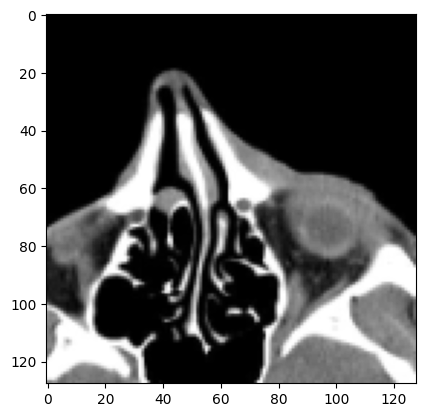

In [12]:
case = 0
slice = 44
plt.imshow(img_set[case,:,:,slice],cmap='gray')

In [13]:
label[case,:]

array([0., 0., 1., 0.], dtype=float32)